In [2]:
import sys
import os
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join('..')))

from utilities.plotting import LossPlotter

In [3]:
import time
import random
plotter = LossPlotter(smoothing=0.9)

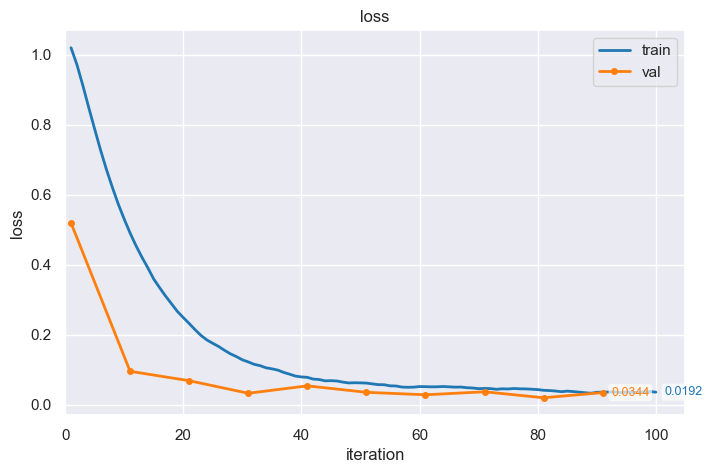

In [4]:
print("running")
for i in range(100):
  train_loss = 1 / (i + 1) + random.uniform(0, 0.05)
  val_loss = 1 / (i + 2) + random.uniform(0, 0.05) if i % 10 == 0 else None
  plotter.update(train_loss, val_loss)
  time.sleep(0.05)

In [5]:
import math
import random

def generate_simulated_loss(iterations=5000):
    # Initialize lists to hold the loss values
    train_loss = []
    val_loss = []
    
    # Constants to control the shape of the curve
    # k_train and k_val control the decay rate (a larger denominator means slower decay)
    K_TRAIN_DECAY = 1200 
    K_VAL_DECAY = 850    
    
    # C_base is the asymptotic minimum loss
    C_TRAIN_BASE = 1.5
    C_VAL_BASE = 1.3
    
    # C_amp is the starting amplitude of the decay (i.e., the difference 
    # between starting loss and base loss)
    C_TRAIN_AMP = 3.5
    C_VAL_AMP = 3.2


    print(f"Simulating loss over {iterations} iterations...")

    # Loop through each iteration to calculate the loss
    for i in range(1, iterations + 1):
        
        # --- Train Loss Calculation ---
        
        # Exponential term: Decay from C_AMP down to 0
        exp_train = C_TRAIN_AMP * math.exp(-i / K_TRAIN_DECAY)
        
        # Random noise: A small, high-frequency fluctuation
        noise_train = random.uniform(-0.15, 0.15)
        
        # Total train loss: Base minimum + Exponential decay + Noise
        current_train_loss = C_TRAIN_BASE + exp_train + noise_train
        
        # Append the calculated loss (ensure it doesn't go below 1.0)
        train_loss.append(max(current_train_loss, 1.0))
        

        # --- Validation Loss Calculation ---
        
        # Exponential term: Decay term (designed to slightly faster/lower than train)
        exp_val = C_VAL_AMP * math.exp(-i / K_VAL_DECAY)
        
        # Random noise: Slightly smaller noise for a smoother val curve
        noise_val = random.uniform(-0.1, 0.1)
        
        # Total validation loss: Base minimum + Exponential decay + Noise
        current_val_loss = C_VAL_BASE + exp_val + noise_val
        
        # Append the calculated loss (ensure it doesn't go below 0.8)
        val_loss.append(max(current_val_loss, 0.8))


    print("Simulation complete. Data available in 'train_loss' and 'val_loss'.")
    return train_loss, val_loss

# Run the simulation
train_loss, val_loss = generate_simulated_loss(iterations=5000)

# Print a few samples to show the data structure
print("\n--- Sample Output (First 5 Iterations) ---")
for i in range(5):
    print(f"Iteration {i+1:4d}: Train Loss = {train_loss[i]:.4f}, Val Loss = {val_loss[i]:.4f}")
    
# Print the final values
print("\n--- Final Values ---")
print(f"Iteration 5000: Train Loss = {train_loss[-1]:.4f}, Val Loss = {val_loss[-1]:.4f}")


Simulating loss over 5000 iterations...
Simulation complete. Data available in 'train_loss' and 'val_loss'.

--- Sample Output (First 5 Iterations) ---
Iteration    1: Train Loss = 5.1266, Val Loss = 4.4672
Iteration    2: Train Loss = 4.9156, Val Loss = 4.5913
Iteration    3: Train Loss = 5.0133, Val Loss = 4.4647
Iteration    4: Train Loss = 4.9697, Val Loss = 4.5171
Iteration    5: Train Loss = 4.8965, Val Loss = 4.5233

--- Final Values ---
Iteration 5000: Train Loss = 1.6208, Val Loss = 1.2497


In [6]:
# NEW VERSION

import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, List
from itertools import zip_longest

class LossTracker:
	# initialize settings
	def __init__(self):
		# sns.set_style("white")
		self.fig = plt.figure()

		self.x = []
		self.y_train = []
		self.y_val = []

		# whole loss plot
		self.ax1 = self.fig.add_subplot(1, 1, 1)
		sns.lineplot(x=self.x, y=self.y_train, ax=self.ax1)
		sns.lineplot(x=self.x, y=self.y_val, ax=self.ax1)
		self.train_line, self.val_line = None, None

		#self.fig.canvas.draw_idle()
	
	# Add singular value to data tracker
	def add_points(self, 
		train: float, 
		val: Optional[float] = None, 
		x: Optional[int] = None
	):
		current_x = x or (self.x[-1] + 1 if self.x else 1)
		self.x.append(current_x)
		self.y_train.append(train)
		self.y_val.append(val)

	# Add batch of values to data tracker 
	def add_points_batch(self, 
		trains: List[float], 
		vals: List[Optional[float]] = None,
		x: Optional[int] = None
	):
		for train, val in zip_longest(trains, vals):
			self.add_points(train, val)

	# Render and return figure to print
	def get_updated_figure(self):
		if self.y_train:
			if self.train_line:
				self.train_line.set_data(self.x, self.y_train)
			else:
				sns.lineplot(x=self.x, y=self.y_train, ax=self.ax1)
				self.train_line = self.ax1.lines[0]

		if any(y is not None for y in self.y_val):
			if self.val_line:
				self.val_line.set_data(self.x, self.y_val)
			else:
				sns.lineplot(x=self.x, y=self.y_val, ax=self.ax1)
				self.val_line = self.ax1.lines[1]
		
		self.ax1.relim()
		self.ax1.autoscale_view()

		self.fig.canvas.draw_idle()
		return self.fig

Simulating loss over 5000 iterations...
Simulation complete. Data available in 'train_loss' and 'val_loss'.


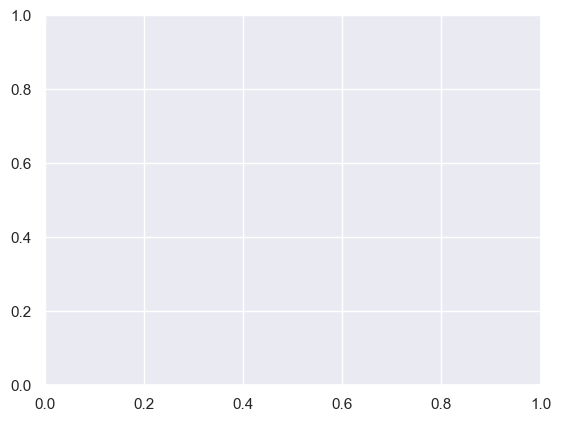

In [7]:
lt = LossTracker()
train_data, val_data = generate_simulated_loss()
val_data = [x*1.25 if i % 50 == 0 else None for i, x in enumerate(val_data)]
from IPython.display import display, clear_output

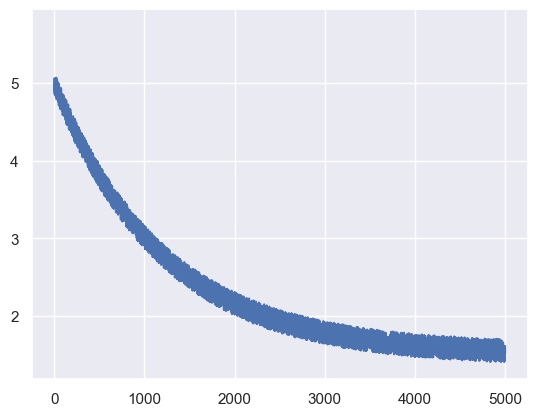

5000it [00:08, 581.36it/s]


In [8]:
i = 0
for t, v in tqdm(zip(train_data, val_data)):
  i += 1
  lt.add_points(t, v)
  if i % 20 == 0:
    fig = lt.get_updated_figure()
    clear_output(wait=True)
    display(fig)

In [9]:
plotter = LossPlotter(smoothing=0.9)

train
val


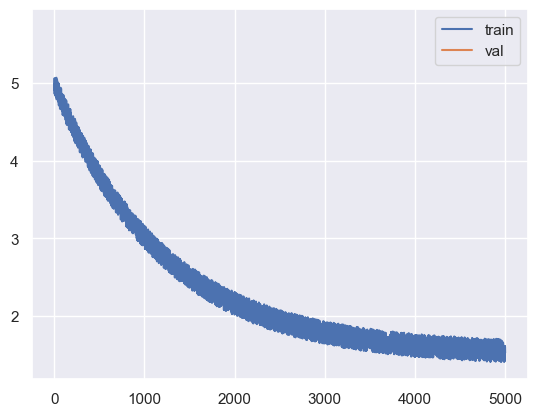

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = sns.lineplot(x=range(2500), y=train_data[:2500], ax=ax, label="train")
ax = sns.lineplot(x=range(2500), y=val_data[:2500], ax=ax, label="val")
train_line, val_line = ax.get_lines()
print(train_line.get_label())
print(val_line.get_label())


train_line.set_data(range(5000), train_data)
val_line.set_data(range(5000), val_data)


ax.relim()
ax.autoscale_view()
fig.canvas.draw_idle()

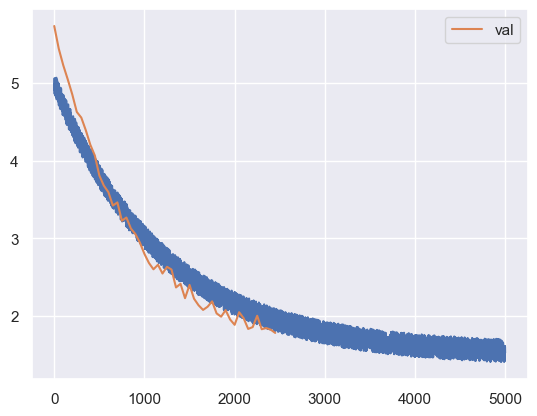

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.lineplot(x=range(2500), y=train_data[:2500], ax=ax)
sns.lineplot(x=range(2500), y=val_data[:2500], ax=ax, label="val")
train_line, val_line = ax.get_lines()
train_line.set_data(range(5000), val_data)
train_line.set_data(range(5000), train_data)


ax.relim()
ax.autoscale_view()
fig.canvas.draw_idle()

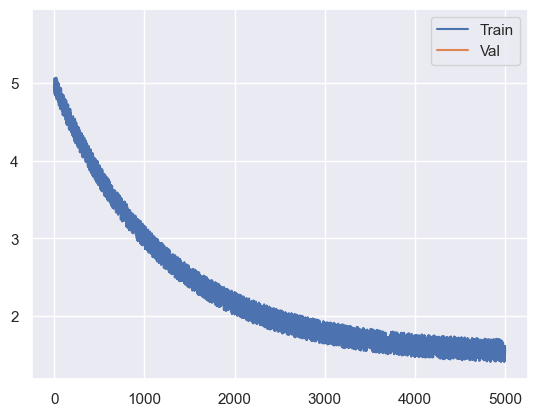

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- initial setup ---
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots()

# initial Seaborn style (once)
sns.lineplot(x=range(2500), y=train_data[:2500], ax=ax, label='Train')
sns.lineplot(x=range(2500), y=val_data[:2500], ax=ax, label='Val')

# grab the two matplotlib Line2D objects
train_line, val_line = ax.get_lines()

# --- later update logic ---
train_line.set_data(range(5000), train_data)
val_line.set_data(range(5000), val_data)

# update axis limits
ax.relim()
ax.autoscale_view()

# redraw
fig.canvas.draw_idle()
plt.pause(0.001)  # only needed for interactive/live plots


<a list of 4 Line2D objects>


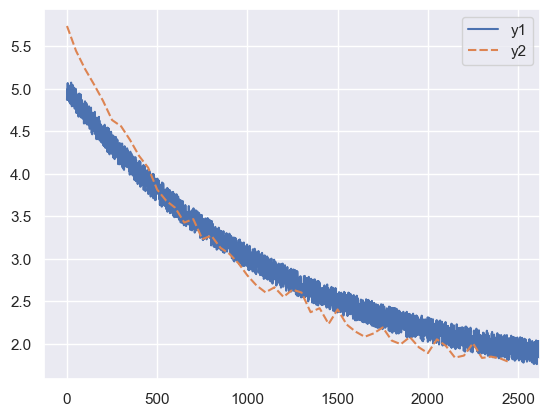

In [ ]:
data = {
	'y1': train_data[:2500],
	'y2': val_data[:2500]
}
ax2 = 
lines = ax2.get_lines()
print(ax2.get_lines())
